# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 3382.6434977722574 [ 0.78828104 -0.25583186 -2.43537611 -2.32731965]
iteration 1 accepted 3022.7735435104205 [-0.72465314 -0.21700981 -1.57045394  2.78127005]
iteration 2 accepted 3018.2481668089385 [-1.310665   -0.24084828  0.44269854  0.22290955]
iteration 3 accepted 2056.115525217395 [ 0.20243478  0.19751573  0.27120954 -1.16197635]
iteration 4 accepted 1876.7235844046004 [-0.0321225  -0.02054432  0.47835048 -1.13929115]
iteration 5 accepted 1800.3107961188991 [-0.07259212 -0.06111942  0.56373736 -0.74267399]
iteration 6 accepted 1751.3869399066125 [-0.05268293 -0.06704825  0.53291771 -0.58437385]
iteration 7 accepted 1747.2511777792645 [ 0.03042222  0.04515866  0.56073641 -0.4994535 ]
iteration 8 accepted 1729.1145594901036 [ 0.02233906  0.02181345  0.53574972 -0.45589747]
iteration 9 accepted 1727.5037207841106 [-0.01621178  0.0886979   0.41797701 -0.55103479]
iteration 10 accepted 1710.205839713392 [-0.00810252  0.02815292  0.44063686 -0.48422101]
iteration 1

iteration 90 accepted 1518.7025454170166 [ 0.00828826 -0.1686515   0.10814129 -0.24210244]
iteration 91 accepted 1517.6591648415285 [ 0.01053682 -0.16610468  0.1057122  -0.2378074 ]
iteration 92 accepted 1517.602113593342 [ 0.00692846 -0.17117738  0.10056196 -0.24380068]
iteration 93 accepted 1517.5038478558708 [-0.00536007 -0.18255436  0.09685291 -0.26050719]
iteration 94 accepted 1514.986801353385 [-0.0023323  -0.17848681  0.10015167 -0.25503079]
iteration 95 accepted 1514.0019198248422 [ 0.00498279 -0.17579099  0.09715103 -0.24984075]
iteration 96 accepted 1513.0269600819308 [ 0.00796912 -0.17271899  0.09785899 -0.24518847]
iteration 97 accepted 1512.2044964159784 [ 0.01091247 -0.17250138  0.09496551 -0.24367633]
iteration 98 accepted 1511.3110934269253 [ 0.01137736 -0.17203739  0.09493429 -0.24254648]
iteration 99 accepted 1510.511912112369 [ 0.01237101 -0.17290838  0.09223281 -0.24266051]
iteration 100 accepted 1509.6471831123665 [ 0.01160589 -0.17371904  0.09209828 -0.24313114]
i

iteration 179 accepted 1472.8014966599692 [ 0.00554971 -0.30140934  0.00505351 -0.41143874]
iteration 180 accepted 1472.6854212523062 [ 0.01373625 -0.29795874 -0.00820109 -0.40881569]
iteration 181 accepted 1472.233957672425 [ 0.00542777 -0.3058784   0.00180323 -0.42125149]
iteration 182 accepted 1469.9388052508261 [ 1.12060813e-02 -2.95072558e-01 -2.16895690e-04 -4.07411313e-01]
iteration 183 accepted 1469.8867555800562 [ 0.04756358 -0.27891433  0.00970824 -0.38113351]
iteration 184 accepted 1468.3215141121839 [ 0.04647512 -0.27956092  0.00795157 -0.38137878]
iteration 185 accepted 1467.849671569202 [ 0.04764749 -0.2839619   0.00530773 -0.38522687]
iteration 186 accepted 1467.7565522881457 [ 0.04342321 -0.28346955  0.00381923 -0.3837108 ]
iteration 187 accepted 1467.4233219163038 [ 0.04022028 -0.28653891  0.00565416 -0.38725002]
iteration 188 accepted 1466.8689491288044 [ 0.03908654 -0.2854484   0.00358393 -0.38574646]
iteration 189 accepted 1466.5705930710744 [ 0.04105605 -0.28634287

iteration 268 accepted 1435.983437315625 [ 0.05518001 -0.33752907 -0.03506078 -0.47046298]
iteration 269 accepted 1435.8218641990943 [ 0.05680331 -0.33960982 -0.02914504 -0.47389572]
iteration 270 accepted 1435.2079561398748 [ 0.0563339  -0.3396889  -0.03765845 -0.47456005]
iteration 271 accepted 1434.9067082569609 [ 0.05558727 -0.3401493  -0.03091901 -0.47518462]
iteration 272 accepted 1434.4099934845121 [ 0.05587334 -0.34038912 -0.03774688 -0.47559308]
iteration 273 accepted 1434.0926963883803 [ 0.05413403 -0.34120292 -0.03072276 -0.47715653]
iteration 274 accepted 1433.2955200703755 [ 0.05382098 -0.34206021 -0.03972944 -0.47820171]
iteration 275 accepted 1432.9121079715474 [ 0.0531446  -0.34233197 -0.03240246 -0.47800218]
iteration 276 accepted 1432.4297904859443 [ 0.05377441 -0.34284557 -0.03900377 -0.47842831]
iteration 277 accepted 1432.3267398108526 [ 0.05382657 -0.34558747 -0.03094462 -0.48193061]
iteration 278 accepted 1431.5842612296965 [ 0.05344768 -0.3456201  -0.04099789 -0

iteration 359 accepted 1408.4779629181314 [ 0.05919207 -0.36441561 -0.04980998 -0.51930402]
iteration 360 accepted 1408.2766189977085 [ 0.0598221  -0.36286785 -0.05784839 -0.51708752]
iteration 361 accepted 1407.7217843562585 [ 0.05755178 -0.36521092 -0.05001582 -0.5201862 ]
iteration 362 accepted 1407.5615616422485 [ 0.05833435 -0.36338312 -0.05832287 -0.51743501]
iteration 363 accepted 1407.0549111593564 [ 0.05586805 -0.36628605 -0.05028342 -0.52124643]
iteration 364 accepted 1407.0261932551641 [ 0.05689053 -0.36454499 -0.05883329 -0.51846091]
iteration 365 accepted 1406.5465852461816 [ 0.05468781 -0.36759594 -0.05050858 -0.52252492]
iteration 366 accepted 1406.1985218797508 [ 0.05588741 -0.36474375 -0.05371516 -0.51803796]
iteration 367 accepted 1406.0122183446363 [ 0.05899659 -0.36483601 -0.04822542 -0.51696999]
iteration 368 accepted 1405.762416162613 [ 0.0599686  -0.36436683 -0.05361158 -0.51635603]
iteration 369 accepted 1405.6329277157772 [ 0.06110841 -0.36495274 -0.0478993  -0

iteration 449 accepted 1385.0326974019627 [ 0.06548252 -0.37404527 -0.05196485 -0.53333581]
iteration 450 accepted 1384.595246166518 [ 0.06524306 -0.37400175 -0.06125864 -0.53384947]
iteration 451 accepted 1384.507162141367 [ 0.06325104 -0.37523194 -0.05208339 -0.53628564]
iteration 452 accepted 1383.970946098961 [ 0.06310797 -0.37550561 -0.0627648  -0.53718906]
iteration 453 accepted 1383.952677748203 [ 0.0607147  -0.37717775 -0.0523058  -0.53952538]
iteration 454 accepted 1383.4120387964495 [ 0.06091098 -0.37732816 -0.06387242 -0.54019894]
iteration 455 accepted 1382.9669324789156 [ 0.06070913 -0.37570645 -0.05636033 -0.53714458]
iteration 456 accepted 1382.856406798363 [ 0.0634708  -0.37542774 -0.06313969 -0.53580545]
iteration 457 accepted 1382.4370849863774 [ 0.0625006  -0.37653403 -0.05576215 -0.53714196]
iteration 458 accepted 1382.374061101394 [ 0.06374803 -0.37574059 -0.06487882 -0.53596815]
iteration 459 accepted 1381.8352547665725 [ 0.06091683 -0.37807861 -0.0561128  -0.5391

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

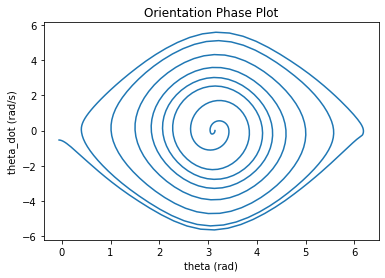

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

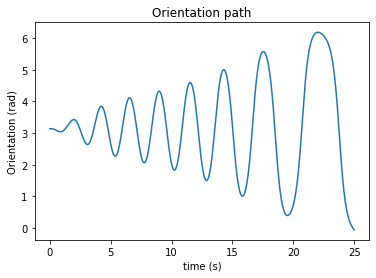

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

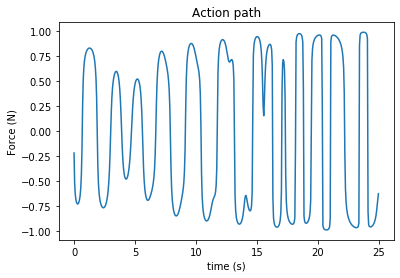

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

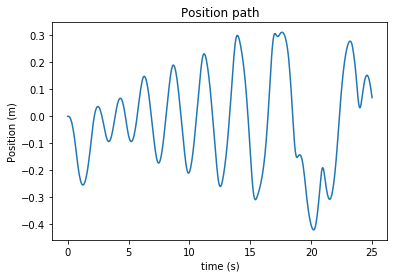

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

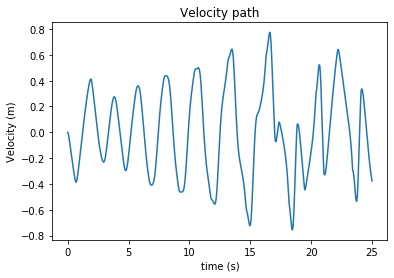

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

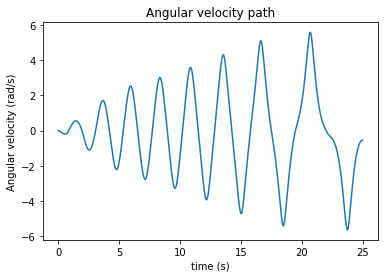

In [17]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

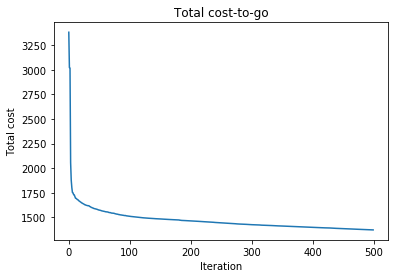

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")